In [1]:
import numpy as np
import pandas as pds
from copy import deepcopy
from random import shuffle

"""
    Different correlations
"""
from scipy.linalg import eigh, cholesky
from scipy.stats import norm, pearsonr

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, './')
from Pareto import *

matplotlib.rcParams['font.family'] = "Sans-serif"
matplotlib.rcParams['font.serif'] = "Arial" #Helvetica
matplotlib.rcParams['font.style'] = "normal"
matplotlib.rcParams['font.weight']='light'
matplotlib.rcParams['mathtext.fontset'] = "custom"
matplotlib.rcParams['mathtext.rm'] = "Arial"

In [3]:
## Choice of cholesky or eigenvector method.
method = 'cholesky'
## method = 'eigenvectors'

num_samples = 2300 ## similar to the number of MLIP models
dim = 50 ## similar to the number of properties

### Generating correlated random variable variables using Cholesky method
**Note**: the method currently can only be applied on positive correlations. If the target correlation is negative, we need other algorithms.

In [4]:
corr = 0.3 ## target correlation

## The desired covariance matrix.
## All diagonal terms are 1 and non-diagonal terms are target correlation
## coefficients (Pearson's r). This is suitable because we intend to 
## generate standardized random variables.

## Note that if the variables are not standardized, this step should be
## modified.
r = []
for ix in range(dim):
    tmp = []
    for iy in range(dim):
        if iy==ix:
            tmp.append(1)
        else:
            tmp.append(corr)
    r.append(deepcopy(tmp))
r = np.array(r)

## Generate samples from three independent normally distributed random
## variables (with mean 0 and std. dev. 1).
## Here, variables are uncorrelated.
x = norm.rvs(size=(dim, num_samples))

## We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
## the Cholesky decomposition, or the we can construct `c` from the
## eigenvectors and eigenvalues.
if method == 'cholesky':
    ## Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)
else:
    ## Compute the eigenvalues and eigenvectors.
    evals, evecs = eigh(r)
    ## Construct c, so c*c^T = r.
    c = np.dot(evecs, np.diag(np.sqrt(evals)))

## Convert the data to correlated random variables. 
y = np.dot(c, x)

In [5]:
indices = [n for n in range(dim)]
attempts = 250
results = {'N_D': [], 'N_optimal': []}

## Using 2 - 5 dimensions
for ndim in range(2, 6):
    ## Randomly generate 250 Pareto fronts in N_D dimension
    ## Study the N_optimal distribution with these Pareto fronts
    for a in range(attempts):
        ## Randomly select N_D variables (fix N_D),
        ## so that N_optimal will be different every time
        shuffle(indices)

        ## N_D * 2300 matrix
        data = [deepcopy(y[index]) for index in indices[:ndim]]
        ## 2300 * N_D matrix
        ## This is used to find the Pareto fronts.
        t_data = np.transpose(data)
        output = is_pareto_efficient(deepcopy(t_data))
        results['N_D'].append(ndim)
        results['N_optimal'].append(len([n for n in output if n]))
rdf = pds.DataFrame(results)

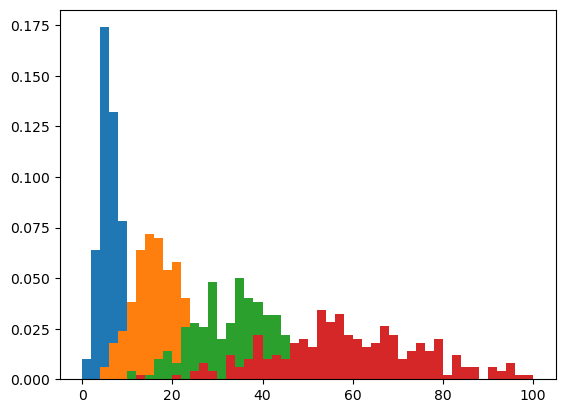

In [6]:
"""
    Post-process: get the distribution (probability density functions, PDFs)
"""
xs = np.linspace(0, 100, 51)
dx = xs[1]-xs[0]
y_sum = []
p_sum = []

for ndim in range(2, 6):
    tmpdf = rdf.loc[rdf['N_D']==ndim]
    p = [n for n in tmpdf['N_optimal']]
    ty, tx, _ = plt.hist(p, bins=xs, density=True)
    y_sum.append(deepcopy(ty))
    p_sum.append(np.median(p))

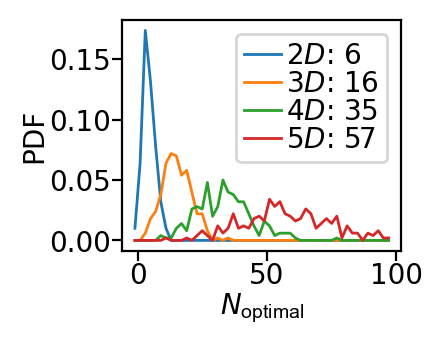

In [7]:
"""
    Show the distributions
"""
fig = plt.figure(figsize=(1.8, 1.5), dpi=200)
ax = plt.subplot(1, 1, 1)

for iy, (ty, tp) in enumerate(zip(y_sum, p_sum)):
    ax.plot([n-dx/2 for n in xs[:-1]], ty, linewidth=1,
            label='{}$D$: {}'.format(iy+2, int(np.median(tp))))
## Figure format

ax.set_xlabel('$N_{\mathrm{optimal}}$', fontsize=10, labelpad=0.5)
ax.set_ylabel('PDF', fontsize=10, labelpad=0.5)
plt.tick_params(axis='both', which='major', labelsize=10, pad=0.5)
lgd = plt.legend(loc='best', fontsize=10, ncol=1, columnspacing=0.4, handlelength=1.3,
                 borderpad=0.3, labelspacing=0, handletextpad=0.2)

plt.show()
plt.clf()
plt.close()

r: 0.29 ; r2: 0.08


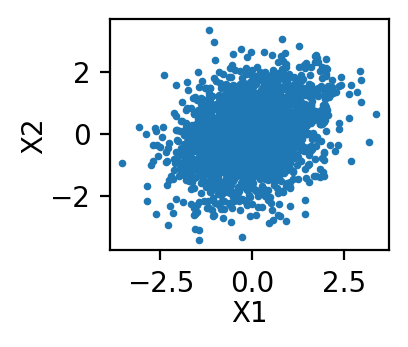

In [12]:
fig = plt.figure(figsize=(1.8, 1.5), dpi=200)
ax = plt.subplot(1, 1, 1)

## Randomly select two variables
## Verify the correlations
shuffle(indices)
r, _ = pearsonr(y[indices[0]], y[indices[11]])
print('r:', round(r, 2), '; r2:', round(r**2, 2))

ax.scatter(y[indices[0]], y[indices[11]], s=3)
ax.set_xlabel('X1', fontsize=10, labelpad=0.5)
ax.set_ylabel('X2', fontsize=10, labelpad=0.5)

plt.show()
plt.clf()
plt.close()